In [55]:
from mouseBehavior import mouseBehaviorData as mbd
import numpy as np
import os, glob
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats

In [3]:
dataframe_dir = r"\\allen\programs\braintv\workgroups\nc-ophys\corbettb\NP_behavior_pipeline\behavior_sessions\ophys_pipeline\dataframes"
dataframe_files = [f for f in os.listdir(dataframe_dir) if 'behaviorHistory.pkl' in f]

In [4]:
dflist = [pd.read_pickle(os.path.join(dataframe_dir, dpath)) for dpath in dataframe_files]
mouseIDs = [int(dpath[:6]) for dpath in dataframe_files]

## Dataframe contains behavior sessions from 67 SLC mice from the ophys pipeline 

In [11]:
popdf = pd.concat(dflist, keys=mouseIDs)
print('Total mice: ' + str(len(popdf.groupby(level=0))))
popdf.loc[popdf['stage'].str.contains('OPHYS')].groupby(level=0).first()['session_datetime_local'].head()

Total mice: 67


431018    2019-02-14 12:10:26.670000-08:00
431023    2019-02-18 11:55:26.668000-08:00
431245    2019-02-22 14:25:18.401000-08:00
431246    2019-03-01 08:32:57.009000-08:00
431249    2019-02-26 14:07:15.569000-08:00
Name: session_datetime_local, dtype: object

## Limit to mice trained on images A: we end up with 35 mice dating back to April (for first ophys session)

In [308]:
imA = popdf['stage'].str.contains('TRAINING_5_images_A_handoff_ready')
imA_mice = popdf.loc[imA_mice].index.get_level_values(0).unique()

imAdf = popdf.loc[imA_mice]
print('Total mice: ' + str(len(imA_df.groupby(level=0))))
imAdf.loc[imAdf['stage'].str.contains('OPHYS')].groupby(level=0).first()['session_datetime_local']

Total mice: 35


435838    2019-04-08 11:30:54.924000-07:00
436662    2019-04-18 09:13:57.308000-07:00
440298    2019-04-18 09:36:48.583000-07:00
442709    2019-04-09 09:10:10.465000-07:00
445002    2019-04-22 09:01:33.022000-07:00
445270    2019-05-07 11:07:57.342000-07:00
445271    2019-05-15 13:36:02.788000-07:00
447663    2019-05-16 12:01:27.222000-07:00
448897    2019-05-17 09:06:08.768000-07:00
448900    2019-05-30 10:48:53.601000-07:00
449441    2019-06-10 08:44:33.799000-07:00
450471    2019-06-06 10:10:41.433000-07:00
450705    2019-06-11 11:31:51.023000-07:00
451787    2019-06-17 12:54:37.113000-07:00
451790    2019-07-06 09:25:59.779000-07:00
453909    2019-08-28 11:35:21.771000-07:00
453911    2019-08-22 09:05:57.330000-07:00
453913    2019-06-24 14:05:29.698000-07:00
456564    2019-06-27 11:03:37.927000-07:00
456915    2019-07-26 10:27:08.157000-07:00
456916    2019-07-01 09:04:42.104000-07:00
456917    2019-06-25 11:16:42.822000-07:00
457766    2019-09-30 13:23:13.528000-07:00
458155    2

### There is a modest drop off in performance from handoff to habituation and a larger drop off for ophys

[Text(0,0,u'last handoff_ready'),
 Text(0,0,u'last habituation'),
 Text(0,0,u'first ophys1')]

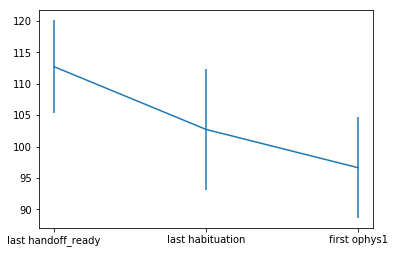

In [305]:
handoff_rewards = []
hab_rewards = []
ophys1_rewards = []
for mid, md in imAdf.groupby(level=0):
    if md['stage'].str.contains('OPHYS_1').sum()>0:  #only take mice that had ophys
        handoff_rewards.append(md['earned_rewards'].loc[md['stage'].str.contains('handoff')].iloc[0])
        hab_rewards.append(md['earned_rewards'].loc[md['stage'].str.contains('habituation')].iloc[0])
        ophys1_rewards.append(md['earned_rewards'].loc[md['stage'].str.contains('OPHYS_1')].iloc[-1])

means = [np.mean(r) for r in [handoff_rewards, hab_rewards, ophys1_rewards]]
sems = [np.std(r)/len(r)**0.5 for r in [handoff_rewards, hab_rewards, ophys1_rewards]]
fig, ax = plt.subplots()
ax.errorbar([0,1,2], means, yerr=sems)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['last handoff_ready', 'last habituation', 'first ophys1'])

### Plot saturation times on handoff ready sessions for all mice (when do mice reach 90% of their earned water?)

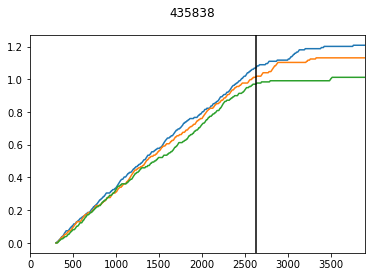

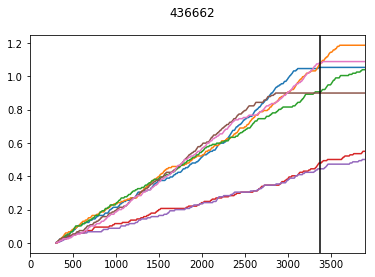

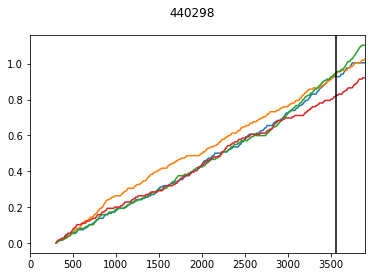

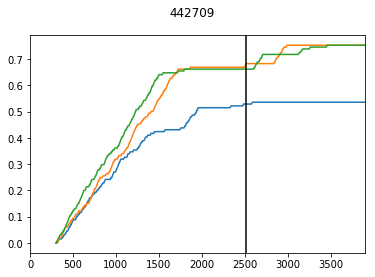

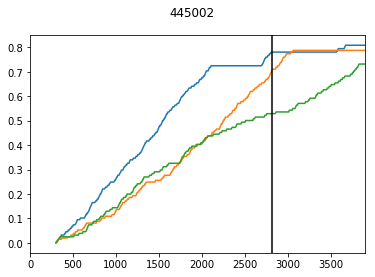

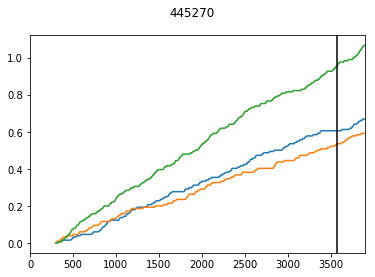

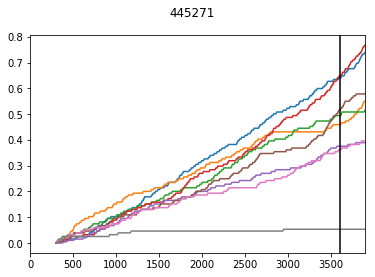

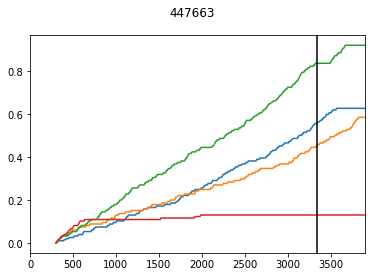

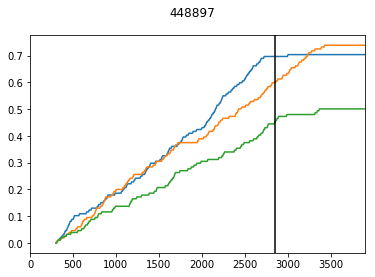

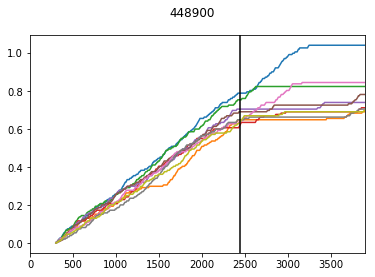

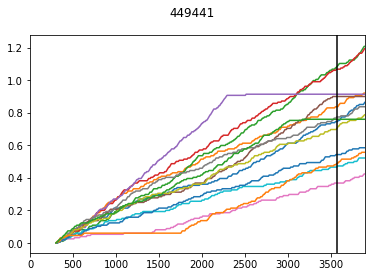

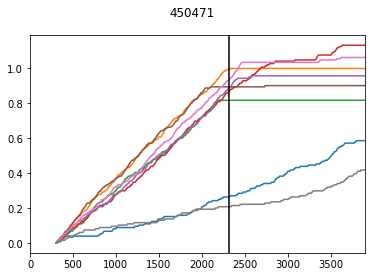

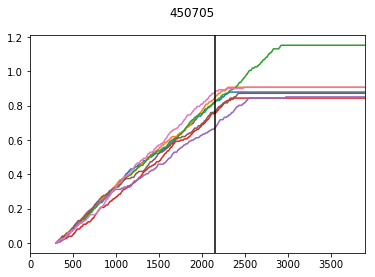

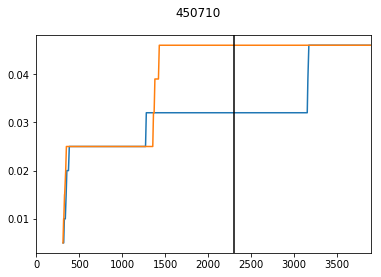

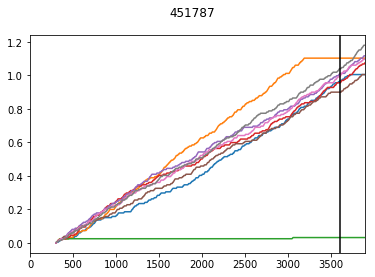

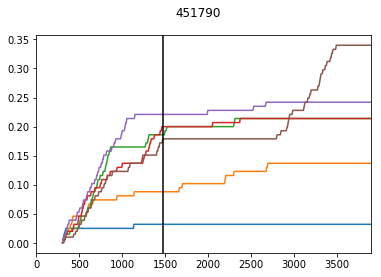

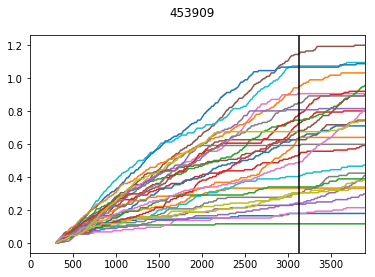

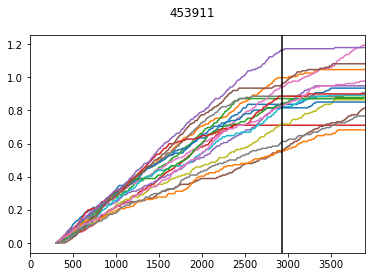

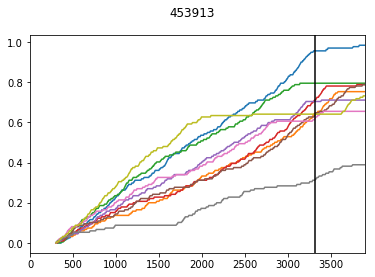

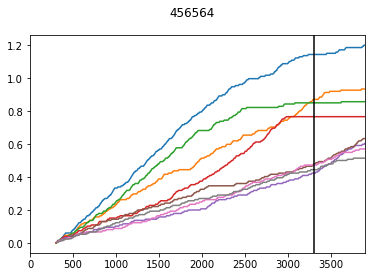

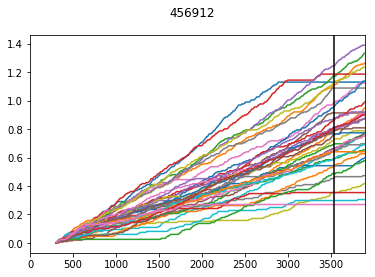

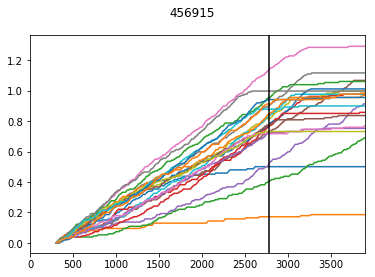

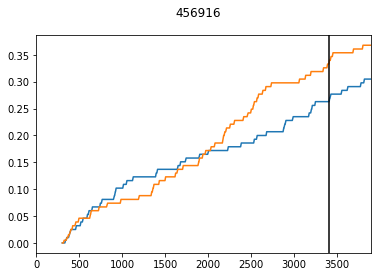

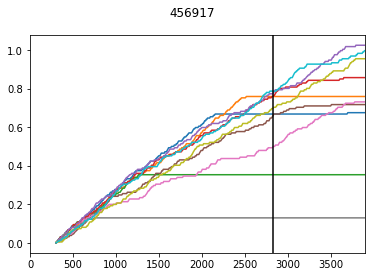

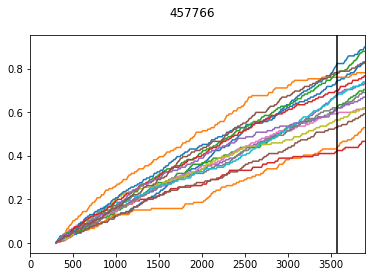

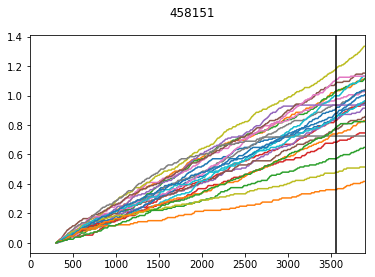

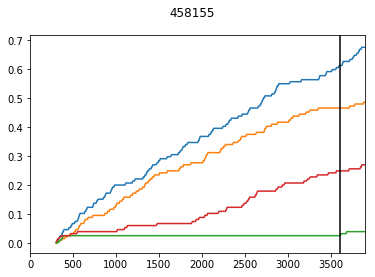

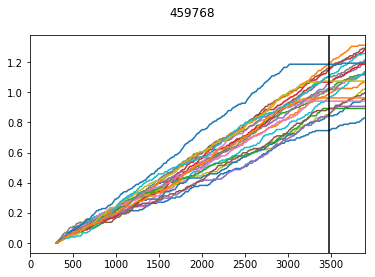

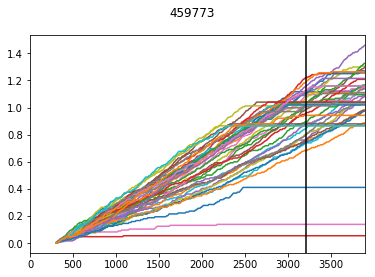

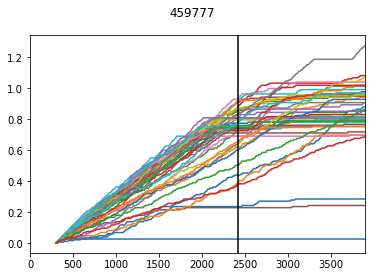

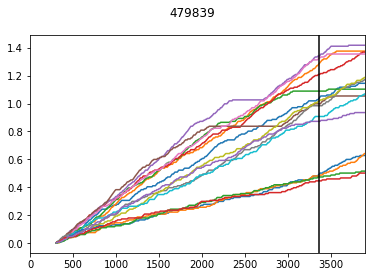

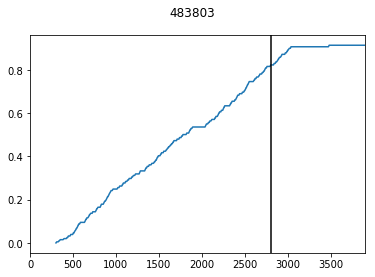

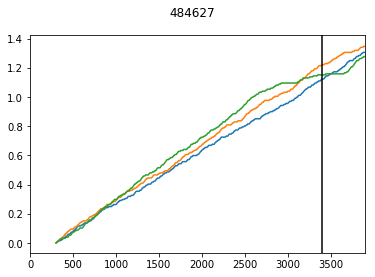

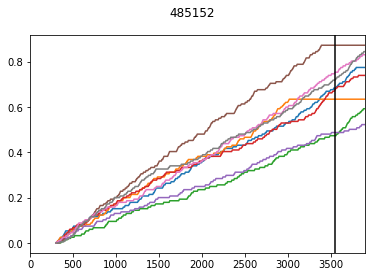

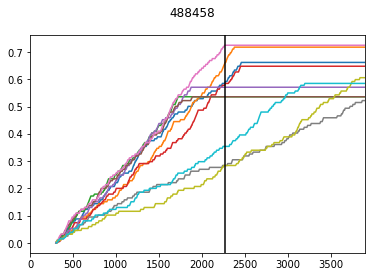

In [138]:
def findSaturationTime(trialdf):
    saturationTrial = np.where(trialdf['cumulative_volume'] > 0.90*trialdf['cumulative_volume'].max())[0][0]
    return np.array(trialdf['endtime'])[saturationTrial]

hr = imAdf['stage'].str.contains('TRAINING_5_images_A_handoff_ready')
hrd = imAdf.loc[hr]

median_saturation_time = []
all_saturation = []
for mid, md in hrd.groupby(level=0):
    fig, ax = plt.subplots()
    fig.suptitle(mid)
    saturationPoints = np.array(md.apply(lambda row: findSaturationTime(row['trials']), axis=1))

    for it, r in md.iterrows():
        ax.plot(r['trials']['endtime'], r['trials']['cumulative_volume'])
    
    median_saturation_time.append(np.median(saturationPoints))
    all_saturation.append(saturationPoints)
    
    ax.axvline(x=np.median(saturationPoints), c='k')
    ax.set_xlim([0, 3900])



### Histogram of saturation times across mice: red line indicates ideal saturation time (90% of total session time), black line indicates median saturation time across mice 

### Issue: about half of the mice saturate before we would like them to.
### Intervention: reduce reward volumes during final training stage to 5 uL

(0, 3600)

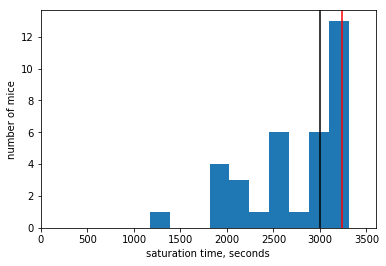

In [140]:
median_saturation_time = np.array(median_saturation_time)-300 #correct for 300s pre session gray period
fig, ax = plt.subplots()
ax.hist(median_saturation_time)
ax.axvline(np.median(median_saturation_time), c='k')
ax.axvline(0.9*3600, c='r')
ax.set_xlabel('saturation time, seconds')
ax.set_ylabel('number of mice')
ax.set_xlim([0, 3600])

### extract handoff and habituation behavior metrics

In [168]:
#correct d prime calculation for limited trials
def corrected_dprime_engaged(trials, reward_rate_thresh = 1):
        
    engagedTrials = (trials['reward_rate'] >= 1) & (trials['response_type'] != 'aborted')
    engagedDF = trials.loc[engagedTrials]
    hits = np.sum(engagedDF['response_type'] == 'HIT')
    misses = np.sum(engagedDF['response_type'] == 'MISS')
    fas = np.sum(engagedDF['response_type'] == 'FA')
    crs = np.sum(engagedDF['response_type'] == 'CR')
    def trial_number_limit(p, N):
        if N == 0:
            return np.nan
        if not pd.isnull(p):
            p = np.max((p, 1. / (2 * N)))
            p = np.min((p, 1 - 1. / (2 * N)))
        return p

    hitRate = trial_number_limit(hits/float(hits + misses), hits + misses)
    faRate = trial_number_limit(fas/float(fas+crs), fas+crs)

    z = [scipy.stats.norm.ppf(r) for r in (hitRate,faRate)]

    return z[0] - z[1]
    
imAdf['corrected_dprime_engaged'] = imAdf.apply(lambda row: corrected_dprime_engaged(row['trials']), axis=1)

c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide
c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\scipy\stats\_distn_infrastructure.py:1914: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\scipy\stats\_distn_infrastructure.py:1914: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)
c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide
c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [182]:
handoff_rewards = []
handoff_dprime = []
habituation_rewards = []
habituation_dprime = []
new_criterion = []
mids = []
for mid, md in imAdf.groupby(level=0):
    if md['stage'].str.contains('OPHYS_1').sum()>0 and md['stage'].str.contains('TRAINING_5_images_A_handoff_ready').sum()>0:
        mids.append(mid)
        hdr_r_min = md['earned_rewards'].loc[md['stage'].str.contains('handoff')].iloc[:3].min()
        hdr_r_mean = md['earned_rewards'].loc[md['stage'].str.contains('handoff')].iloc[:3].mean()
        hdr_dprime = md['corrected_dprime_engaged'].loc[md['stage'].str.contains('handoff')].iloc[:3].mean()
        hab_r = md['earned_rewards'].loc[md['stage'].str.contains('habituation')].mean()
        hab_dp = md['corrected_dprime_engaged'].loc[md['stage'].str.contains('habituation')].mean()
        
        if hdr_r_min>120:
        #if hdr_dprime>1 and hdr_r_min>100:
            new_criterion.append(True)
        else:
            new_criterion.append(False)
        
        handoff_rewards.append(hdr_r_min)
        handoff_dprime.append(hdr_dprime)
        habituation_rewards.append(hab_r)
        habituation_dprime.append(hab_dp)
        
handoff_rewards = np.array(handoff_rewards)
handoff_dprime = np.array(handoff_dprime)
habituation_rewards = np.array(habituation_rewards)
habituation_dprime = np.array(habituation_dprime)
new_criterion = np.array(new_criterion)

### Issue: There are a fair number of mice that get handed off despite the fact that they don't do many trials (<50), or have low d prime when looking over all engaged trials (reward rate > 1 per minute). We hope these mice would benefit from more training.

### Intervention 1: require at least 120 rewards before handoff. 12 of the 31 mice would have passed this new criterion with the current reward volume, another 5 were close to the threshold. It is possible this threshold will be too stringent, but it will allow us to get more data about what happens when mice are kept in training longer.

### Intervention 2: change d prime calculation used for mTrain advancement to the "corrected" version that takes number of trials into account (which is what is shown here). This helps filter out mice with artificially high d prime values because they had low trial counts and no false alarms.

Mice qualifying under new criterion (>120 rewards on last three handoff sessions, red dots): 12
Mice qualifying under old criterion: 31


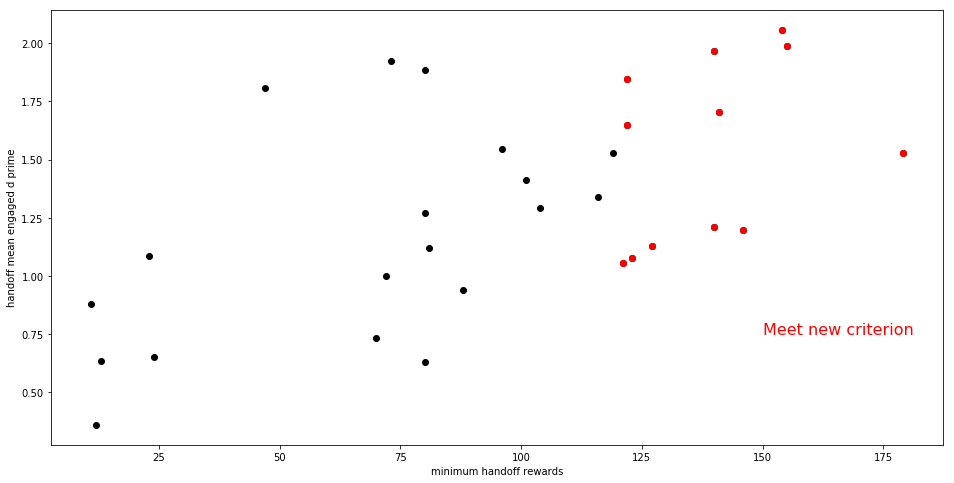

In [183]:
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.plot(handoff_rewards, handoff_dprime, 'ko')
ax.plot(handoff_rewards[new_criterion], handoff_dprime[new_criterion], 'ro')
ax.set_xlabel('minimum handoff rewards')
ax.set_ylabel('handoff mean engaged d prime')
ax.text(150, 0.75, 'Meet new criterion', color='r', size=16)

print('Mice qualifying under new criterion (>120 rewards on last three handoff sessions, red dots): ' + str(np.sum(new_criterion)))
print('Mice qualifying under old criterion: ' + str(len(new_criterion)))


### mice that qualify under new criterion seem to do better on habituation transition, though some mice still fail; need to test with more mice (pilot); black lines are medians

[Text(0,0.5,u'number of mice'), Text(0,0.5,u'number of mice')]

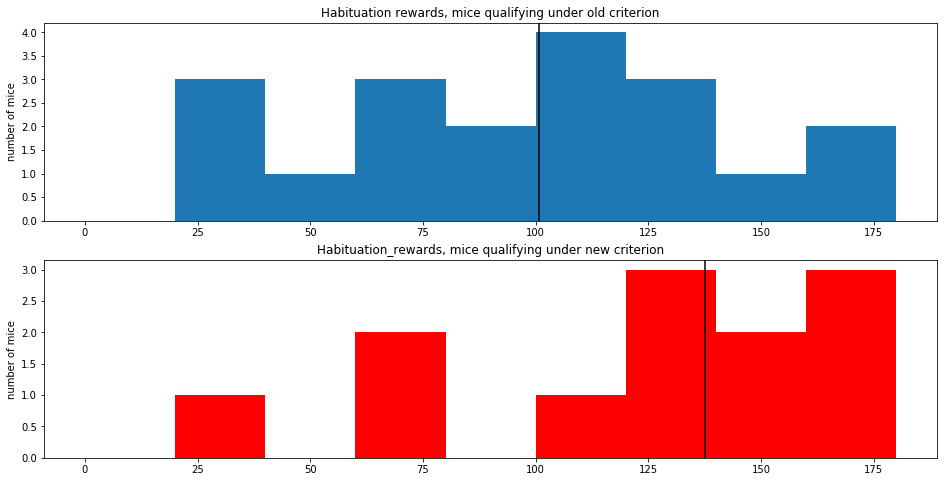

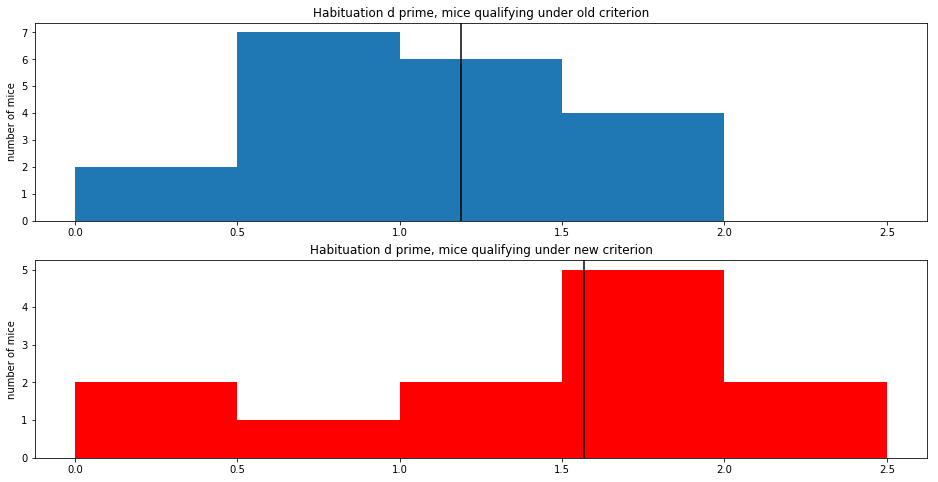

In [187]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches([16, 8])
ax[0].hist(habituation_rewards[~new_criterion], bins = np.arange(0, 200, 20))
ax[0].set_title('Habituation rewards, mice qualifying under old criterion')
ax[0].axvline(np.median(habituation_rewards[~new_criterion]), c='k')
ax[1].hist(habituation_rewards[new_criterion], bins = np.arange(0, 200, 20), color='r')
ax[1].set_title('Habituation_rewards, mice qualifying under new criterion')
ax[1].axvline(np.median(habituation_rewards[new_criterion]), c='k')
[a.set_ylabel('number of mice') for a in ax]

fig, ax = plt.subplots(2,1)
fig.set_size_inches([16, 8])
ax[0].hist(habituation_dprime[~new_criterion], bins = np.arange(0, 3, 0.5))
ax[0].set_title('Habituation d prime, mice qualifying under old criterion')
ax[0].axvline(np.median(habituation_dprime[~new_criterion]), c='k')
ax[1].hist(habituation_dprime[new_criterion], bins = np.arange(0, 3, 0.5), color='r')
ax[1].set_title('Habituation d prime, mice qualifying under new criterion')
ax[1].axvline(np.median(habituation_dprime[new_criterion]), c='k')
[a.set_ylabel('number of mice') for a in ax]

### Will holding mice longer in NSB actually help?
### The under criterion mice (<120 rewards) do a bit better on their last handoff ready session than their first. Our hope is that continued training will further improve their performance. The pilot should help to answer this.


Rewards for first handoff ready session: 73.54545454545455
Rewards for last handoff ready session: 97.63636363636364


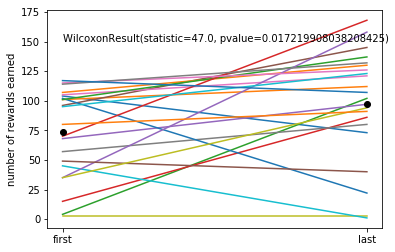

In [276]:
hr = imAdf['stage'].str.contains('TRAINING_5_images_A_handoff_ready')
hrd = imAdf.loc[hr]

first_session_rewards = []
last_session_rewards = []
num_sessions = []
all_rewards = []
for mid, md in hrd.groupby(level=0):
    last_session_rewards.append(md['earned_rewards'].iloc[0])
    first_session_rewards.append(md['earned_rewards'].iloc[-1])
    num_sess = md['stage'].str.contains('TRAINING_5').sum()
    num_sessions.append(num_sess)
    all_rewards.append(md['earned_rewards'].values[::-1])
#     fig, ax = plt.subplots()
#     fig.suptitle(mid)
#     ax.plot(md['session_datetime_local'], md['earned_rewards'], 'ko')

first_session_rewards = np.array(first_session_rewards)
last_session_rewards = np.array(last_session_rewards)

under_criterion = first_session_rewards < 120

fig, ax = plt.subplots()
ax.plot([first_session_rewards[under_criterion], last_session_rewards[under_criterion]])
ax.plot([np.mean(first_session_rewards[under_criterion]), np.mean(last_session_rewards[under_criterion])], 'ko')
ax.set_ylabel('number of rewards earned')
ax.set_xticks([0,1])
ax.set_xticklabels(['first', 'last'])
ax.text(0, 150, scipy.stats.wilcoxon(first_session_rewards[first_session_rewards<120], last_session_rewards[first_session_rewards<120]))

print('Rewards for first handoff ready session: ' + str(np.mean(first_session_rewards[under_criterion])))
print('Rewards for last handoff ready session: ' + str(np.mean(last_session_rewards[under_criterion])))


### on average, mice get a bit better over multiple sessions

Text(0,0.5,u'earned rewards')

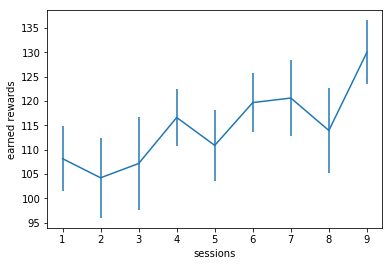

In [293]:
#Find the max number of sessions for which at least 15 mice were kept with NSB in handoff ready
num_sessions = np.array(num_sessions)
num_qualifying = [num_sessions>=n for n in range(num_sessions.max())]
max_sessions = np.where([np.sum(q)>=15 for q in num_qualifying])[0][-1]
qualifying = np.where(num_sessions >= max_sessions)[0] 

#Plot the progress of those mice over the max sessions to see if they get better
sess_nos = []
means = []
sems = []
mouse_nos = []
for ns in range(max_sessions):
    sess_nos.append(ns+1)
    mouse_nos.append(len(qualifying))
    num_rewards = [all_rewards[q][ns] for q in qualifying]
    means.append(np.mean(num_rewards))
    sems.append(np.std(num_rewards)/(mouse_nos[-1]**0.5))


fig, ax = plt.subplots()
ax.errorbar(sess_nos, means, yerr=sems)
ax.set_xlabel('sessions')
ax.set_ylabel('earned rewards')

### maybe switching to image set G will just solve all of the problems?

stage
TRAINING_4_images_A_handoff_ready     53
TRAINING_5_images_A_handoff_ready    414
TRAINING_5_images_B_handoff_ready     65
TRAINING_5_images_G_handoff_ready     56
Name: earned_rewards, dtype: int64


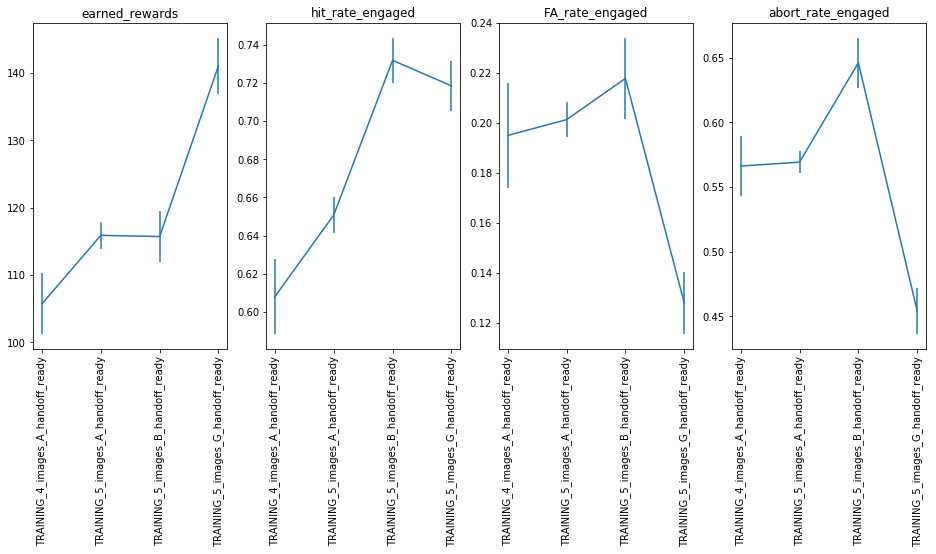

In [309]:
hr = popdf['stage'].str.contains('handoff_ready')
hrd = popdf.loc[hr]

fig, ax = plt.subplots(1,4)
fig.set_size_inches([16,6])

for i, metric in enumerate(['earned_rewards', 'hit_rate_engaged', 'FA_rate_engaged', 'abort_rate_engaged']):
    ax[i].errorbar(np.arange(4), hrd.groupby(['stage']).mean()[metric], hrd.groupby(['stage']).sem()[metric])
    ax[i].set_title(metric)
    ax[i].set_xticks(np.arange(4))
    ax[i].set_xticklabels(popdf['stage'].loc[popdf['stage'].str.contains('handoff_ready')].unique())

    plt.setp(ax[i].get_xticklabels(), rotation=90)
    

print(hrd.groupby(['stage']).count()['earned_rewards'])